$\newcommand{\Sum}{\sum\limits}
\newcommand{\Int}{\int\limits}
\newcommand{\Intf}{\int\limits_{-\infty}^{+\infty}}
\newcommand{\Prod}{\prod\limits}
\newcommand{\Max}{\max\limits}
\newcommand{\Min}{\min\limits}
\newcommand{\Lim}{\lim\limits}
\newcommand{\Var}{\mathbb{V}}
\newcommand{\Exp}{\mathbb{E}}
\newcommand{\argmax}{\arg\max}
\newcommand{\Cov}{\mathrm{Cov}}
\newcommand{\makebold}[1]{\boldsymbol{#1}}
\newcommand{\mean}[1]{\overline{#1}}
\newcommand{\Prob}{\mathcal{P}}
\newcommand{\lp}{\left}
\newcommand{\rp}{\right}
\newcommand{\boldX}{\boldsymbol{X}}
\newcommand{\boldY}{\boldsymbol{Y}}
\newcommand{\boldZ}{\boldsymbol{Z}}
\newcommand{\Poisson}{\mathrm{Poisson}}
\newcommand{\Uniform}{\mathrm{Uniform}}
\newcommand{\Binomial}{\mathrm{Binomial}}
\newcommand{\Gammap}{\mathrm{Gamma}}
\newcommand{\Normal}{\mathcal{N}}
\newcommand{\LogN}{\mathrm{LogN}}
\newcommand{\Exponential}{\mathrm{Exp}}
\newcommand{\Erlang}{\mathrm{Erlang}}
\newcommand{\Cauchy}{C}$

## Математическая статистика в машинном обучении

## Д/З №1

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from itertools import product
from collections import OrderedDict

# Настройка matplotlib-а
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
%matplotlib inline

titlesize = 20
labelsize = 16
legendsize = labelsize
xticksize = 14
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

matplotlib.rc('font', **{'family':'serif'})
# matplotlib.rc('text', usetex=True) 
matplotlib.rc('text', usetex=False)  
# matplotlib.rc('text.latex', unicode=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

## Классы и методы

### 1. EmpiricalDistribution

In [2]:
class EmpiricalDistribution:
    """This class provides empirical distribution functionality. It can be used to
    - estimate empirical cdf and pdf at any points;
    - sample from the empirical distribution;
    - get point masses and cdf arrays for plotting.

    This implementations assumes that
    F(x) = P(X <= x) = Sum_i I[X_i <= x]
    """
    def __init__(self, samples, include=True, seed=None):
        """Initialize empirical distribution.

        Arguments:
        - samples: numpy array, list or tuple of 1D samples
        :param include: bool
        - seed:    random seed for inner generator
        """
        self.set_samples(samples)
        self.set_seed(seed)
        self._include = include  # TODO: setter

    def __len__(self):
        return self.n_samples

    def __str__(self):
        return type(self).__name__

    def set_samples(self, samples):
        """(Re)set samples. Samples are sorted before being stored that takes about O(N logN) operations.
        - samples: numpy array, list or tuple of 1D samples;
        """
        if not isinstance(samples, (list, tuple, np.ndarray)):
            raise TypeError('"samples" must be either np.array, list or tuple.')
        self.n_samples = len(samples)
        self.samples = np.sort(samples)
        self.cdf_data_calculated = False
        self.pdf_data_calculated = False

    def set_seed(self, seed):
        """
        Create an inner generator used to sample data from empirical distribution.
        """
        self.seed = seed
        self.gen = np.random.RandomState(seed)

    def add_sample(self, sample):
        self.add_samples(np.array([sample]))

    def add_samples(self, samples):
        """
        Add additional samples. This operation can be quite costly, since it requires all samples to be sorted,
            that takes about O((n + m) log (n + m)) operations where n is initial number of samples and
            m is the number of samples to add.

        Arguments:
        - samples: numpy array, list or tuple of 1D samples
        """
        self.samples = np.concatenate(self.samples, samples)
        self.samples = np.sort(self.samples)
        self.cdf_data_calculated = False
        self.pdf_data_calculated = False

    def cdf(self, x):
        """
        Returns the CDF value of the empirical distribution at the given point x.

        Arguments:
        - x: number; it is the value to estimate CDF at.

        Returns:
        - F(x): an estimated CDF value.
        """
        if self._include:
            return np.sum(self.samples <= x) / self.n_samples
        return np.sum(self.samples < x) / self.n_samples

    def pdf(self, x):
        """
        Returns the PDF value of the empirical distribution at the given point x.

        Arguments:
        - x: number; it is the value to estimate PDF at.

        Returns:
        - p(x): an estimated PDF value.
        """
        assert False, 'Not defined.'

    def sample(self, size=None, replace=True):
        """Take random uniform samples from inner samples.

        Arguments:
        - size:    the number of samples to return;
        - replace: if True, repeating samples are possible; otherwise, each sample can appear only once,
                   but in this case one could not request more samples that empirical distribution is built upon.

        Returns:
        - numpy array if shape (size,) containing size samples from the stored ones.
        """
        return self.gen.random.choice(self.samples, size=size, replace=replace)

    def get_cdf_data(self, append_borders=0.1):
        """Get data required to plot CDF. This function correctly handles repeating samples (which are typical
        in case of discrete distributions). This function caches the calculated data, so that consecutive calls
        do not require additional computations. This is true until new samples are added
        to the empirical distribution.

        Arguments:
        - append_borders: nonegative number.
            If append_borders > 0, adds border points x_left and x_right such that F(x_left) = 0, F(x_right) = 1.
            It is required for appropriate plotting since otherwise the plots do not show levels 0 and 1 of CDF.
            The values of x_left and x_right are found as follows:
                x_left = min(samples) - append_borders * (max(samples) - min(samples))
                x_right = max(samples) +  append_borders * (max(samples) - min(samples))
            If append_boreders = 0, then does not add these additional points. In this case the lengths of
            returned arrays are equal to the number of samples stored inside.

        Returns shape (points, cumulatives):
        - points: numpy array which contains stored samples (and border points if append_borders > 0)
            in ascending order.
        - cumulatives: numpy array which contains CDF values for the returned points.
            Attention! cumulatives[i] contains CDF value between points points[i] and points[i + 1].
            Thus, if CDF is plotted by means of plt.step(...), then "which='post'" must be used to plot
            it correctly.
        """
        assert append_borders >= 0
        if self.cdf_data_calculated:
            points, cumulatives = self.points, self.cumulatives
        else:
            points, masses = self.get_pdf_data()
            cumulatives = np.array(masses)
            for i in range(1, len(cumulatives)):
                cumulatives[i] += cumulatives[i - 1]
            assert abs(cumulatives[-1] - 1) < 1e-8
            self.cumulatives = cumulatives
            self.cdf_data_calculated = True
        if append_borders > 0:
            x_width = points[-1] - points[0]
            x_low = points[0] - append_borders * x_width
            x_high = points[-1] + append_borders * x_width
            points = np.concatenate([[x_low], points, [x_high]])
            cumulatives = np.concatenate([[0.0], cumulatives, [1.0]])
        return points, cumulatives

    def get_pdf_data(self):
        """
        Get data required to plot PDF. This function correctly handles repeating samples (which are typical
        in case of discrete distributions). This function caches the calculated data, so that consecutive calls
        do not require additional computations. This is true until new samples are added
        to the empirical distribution.
        """
        if self.pdf_data_calculated:
            return self.points, self.masses
        prev_x = -np.inf
        x = []
        y = []
        for curr_x in self.samples:
            if curr_x == prev_x:
                y[-1] += 1
            else:
                y.append(1)
                x.append(curr_x)
                prev_x = curr_x
        self.points = np.array(x)
        self.masses = np.array(y) / self.n_samples
        self.pdf_data_calculated = True
        return self.points, self.masses

### 2. Plotters

In [3]:
def plot_empirical_pdf(x, y, ax, grid=True, color='k', border_ext=0.05,
                       xlim=None, ylim=None,
                       xlabel=None, ylabel=None, title=None, label=None,
                       arrowwidth=None, headwidth=3, headlength=5,
                       verbose=False):
    """
    Plot PDF of empirical (discrete) distribution.
    - ax:          This is the axis to plot data in.
    - grid:        If True, grid is plotted; default is True.
    - color:       Color for plotting arrows (delta-functions); default is black ('k').
    - border_ext:  Vertical and horizontal ranges will be expaned by (bordered_ext * 100)% of data ranges; 
        this parameter is not taken into account for axis X or Y if xlim or ylim are passed, respectively.
    - xlim:        Tuple (xmin, xmax); eliminates effect of border_ext.
    - ylim:        Tuple (ymin, ymax); eliminates effect of border_ext.
    - xlabel:      Lable for axis X.
    - ylabel:      Label for axis Y.
    - title:       title.
    - label:       Label to be shown in legend.
    - arrowwidth:  The absolute width of arrows used to represent delta functions of discrete PDF.
    - headwidth:   The relative width of arrows' heads; the default value is 3 absolute arrow widths.
    - headlength: 
    - verbose:     If True, prints debug information; default is False.
    """
    assert len(x) == len(y)
    x_width = np.max(x) - np.min(x) # ширина по оси X
    y_width = np.max(y)             # ширина по оси Y (минимальное значение - 0)
    if verbose:
        print('plot_point_masses: x_width = {}, y_width = {}, border_ext = {}'.format(x_width, y_width, border_ext))
    if arrowwidth is None:
        arrowwidth = 0.005 * y_width
    else:
        arrowwidth = arrowwidth * y_width
    X = x
    Y = np.zeros_like(X)
    U = np.zeros_like(X)
    V = y
    ax.quiver(X, Y, U, V, units='y', scale=1, scale_units='y', zorder=2,
              width=arrowwidth, headwidth=headwidth, headlength=headlength, color=color, label=label)
    
    x_low  = np.min(x) - border_ext * x_width
    x_high = np.max(x) + border_ext * x_width
    y_low = 0
    y_high = np.max(y) + border_ext * y_width
    # GRID
    if grid: ax.grid(which='both', linestyle='--', alpha=0.5)
    # LIMITS
    if xlim is None: xlim = (x_low, x_high)
    if ylim is None: ylim = (y_low, y_high)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if verbose:
        print('plot_point_masses: xlim is set to ({:.2f}, {:.2f})'.format(xlim[0], xlim[1]))
        print('plot_point_masses: ylim is set to ({:.2f}, {:.2f})'.format(ylim[0], ylim[1]))
    # LABELS
    if xlabel is not None: ax.set_xlabel(xlabel)
    if ylabel is not None: ax.set_ylabel(ylabel)
    if title is not None:  ax.set_title(title)
    return ax


def plot_empirical_cdf(points, cumulatives, ax, grid=True, color='b', border_ext=0.05, 
                       xlim=None, ylim=None, xlabel=None, ylabel=None, title=None, label=None,
                       verbose=False):
    """
    Plot CDF of empirical (discrete) distribution.
    - points:      Coordinates of point masses
    - cumulatives: CDF values.
        It is assumed, that cumulatives[i] gives CDF value at intervals [points[i], points[i + 1]]
    - ax:          This is the axis to plot data in.
    - grid:        If True, grid is plotted; default is True.
    - color:       Color for plotting CDF; default is blue ('b').
    - border_ext:  Vertical and horizontal ranges will be expaned by (bordered_ext * 100)% of data ranges; 
        this parameter is not taken into account for axis X or Y if xlim or ylim are passed, respectively.
    - xlim:        Tuple (xmin, xmax); eliminates effect of border_ext.
    - ylim:        Tuple (ymin, ymax); eliminates effect of border_ext.
    - xlabel:      Lable for axis X.
    - ylabel:      Label for axis Y.
    - title:       title.
    - label:       Label to be shown in legend.
    - verbose:     If True, prints debug information; default is False.
    """
    y_low = 0; y_high = 1.0 + border_ext
    
    x_min = points[0]
    x_max = points[-1]
    x_width = x_max - x_min
    x_low  = x_min - border_ext * x_width
    x_high = x_max + border_ext * x_width

    ax.step(points, cumulatives, where='post', label=label, color=color, zorder=2)
    # GRID
    if grid: ax.grid(which='both', linestyle='--', alpha=0.5)
    # LIMITS
    if xlim is None: xlim = (x_low, x_high)
    if ylim is None: ylim = (y_low, y_high)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if verbose:
        print('plot_point_masses: xlim is set to ({:.2f}, {:.2f})'.format(xlim[0], xlim[1]))
        print('plot_point_masses: ylim is set to ({:.2f}, {:.2f})'.format(ylim[0], ylim[1]))
    # LABELS
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if title  is not None:
        ax.set_title(title)
    return ax 

### 3. Bootstrap

In [4]:
class Bootstrap:
    """This class provides bootstrap functionality:
    - it can be used to generate bootstrap samples
    - it can be used to estimate three types of bootstrap confidence intervals
    """
    def __init__(self, samples, functional=None, seed=1):
        """
        - samples:    Numpy array, list or tuple of samples.
        - seed:       Nonnegative integer; seed to initialize inner generator used for subsampling.
        - functional: A callable entity which accepts bootstrap samples and finds required statistic.
        """
        self.samples = np.array(samples)
        self.set_seed(seed)
        self.functional = functional
        self.statistics = []
        if self.functional is not None:
            self.func_init = self.functional(self.samples)

    def set_seed(self, seed):
        """Initializes inner generator with provided seed.
        """
        self.seed = seed
        self.gen = np.random.RandomState(seed)

    def generate(self, size=None, return_samples=True):
        """
        Arguments:
        - size:            Number of samples to bootstrap; by default it is the number of stored samples.
        - return_samples:  If True, function returns generated samples; otherwise returns nothing.

        Returns generated samples in numpy array of shape (size, ) if return_samples is True.
        Otherwise returns None.
        """
        if size is None:
            size = len(self.samples)
        subsamples = self.gen.choice(self.samples, size=size)
        if self.functional is not None:
            self.statistics.append(self.functional(subsamples))
        if return_samples:
            return subsamples

    def get_statistics(self):
        """
        Returns all calculated estimates in a list. It makes sense only if "functional" passed to the constructor is not None.
        """
        return list(self.statistics)

    def get_init_estimate(self):
        """
        Returns the value of statistics calculated on initial samples passed to the constructor.
        """
        return self.func_init

    def get_interval(self, alpha=0.05, conf_type='normal'):
        """
        Returns 1 - alpha confidence interval of type "normal".

        Arguments:
        - alpha:     (1-alpha) confidence intervals.
        - conf_type: "normal", "centra", "percentile".
        """
        if conf_type == 'normal':
            return self.get_normal_interval(alpha)
        if conf_type == 'central':
            return self.get_central_interval(alpha)
        if conf_type == 'percentile':
            return self.get_percentile_interval(alpha)
        assert False

    def get_normal_interval(self, alpha):
        # Нормальная оценка
        z = abs(stats.norm().ppf(alpha / 2))
        func_std = np.std(self.statistics)
        left, right = self.func_init - z * func_std, self.func_init + z * func_std
        return (left, right)

    def get_central_interval(self, alpha):
        # Центральный интервал
        left = 2 * self.func_init - np.percentile(self.statistics, 100 * (1 - alpha / 2))
        right = 2 * self.func_init - np.percentile(self.statistics, 100 * (alpha / 2))
        return (left, right)

    def get_percentile_interval(self, alpha):
        # Интервал на основе процентилей
        left = np.percentile(self.statistics, 100 * alpha / 2)
        right = np.percentile(self.statistics, 100 * (1 - alpha / 2))
        return (left, right)

In [5]:
def get_all_bootstrap_intervals(bootstrap, alpha):
    """
    Given Bootstrap object this function aggregates all bootstrap confendence intervals into a dict object.
    """
    data = OrderedDict()
    data['alpha'] = alpha
    data['estimate'] = bootstrap.get_init_estimate()
    data['normal'] = bootstrap.get_normal_interval(alpha)
    data['central'] = bootstrap.get_central_interval(alpha)
    data['percentile'] = bootstrap.get_percentile_interval(alpha)
    return data

def plot_confidence_intervals(data, ax, grid=True, legend=True, ylabel=None, title=None):
    """
    This function plots confidence intervals based on the provided data.
    
    Arguments:
    - data:   (dict) Dictionary must contain 'alpha' and 'estimate' values where:
      - alpha: is the parameter of the confidence intervals to plot;
      - estimate: is the estimated value of the parameter of interest.
    - ax:     (Axis) 
    - grid:   (bool)
    - legend: (bool)
    - ylabel: (str)
    - title:  (str)
    
    Returns the axis object passed to the function.
    """
    n = 1
    alpha = data['alpha']
    if 'true' in data:
        low, upp = data['true']
        if 'true_estimate' in data:
            estimate = data['true_estimate']
        else:
            estimate = data['estimate']
        ax.errorbar([n], [estimate], yerr=[[estimate - low], [upp - estimate]], 
                    fmt='s', color='r', ecolor='k', elinewidth=2, capsize=10, 
                    capthick=1, label='True {}%-interval'.format(int(100 * (1 - alpha))))
        n += 1
        
    estimate = data['estimate']
    if 'normal' in data:
        low, upp = data['normal']
        ax.errorbar([n], [estimate], yerr=[[estimate - low], [upp - estimate]], 
                    fmt='s', color='r', ecolor='g', elinewidth=2, capsize=10, 
                    capthick=1, label='Normal {}%-interval'.format(int(100 * (1 - alpha))))
        n += 1
    if 'central' in data:
        low, upp = data['central']
        ax.errorbar([n], [estimate], yerr=[[estimate - low], [upp - estimate]], 
                    fmt='s', color='r', ecolor='b', elinewidth=2, capsize=10, 
                    capthick=1, label='Central {}%-interval'.format(int(100 * (1 - alpha))))
        n += 1
    if 'percentile' in data:
        low, upp = data['percentile']
        ax.errorbar([n], [estimate], yerr=[[estimate - low], [upp - estimate]], 
                    fmt='s', color='r', ecolor='m', elinewidth=2, capsize=10, 
                    capthick=1, label='Percentile {}%-interval'.format(int(100 * (1 - alpha))))
        n += 1
    # Горизонтальные линии
    if 'true' in data:
        low, upp = data['true']
        ax.plot([1, n - 1], [low, low], color='k', linestyle='--')
        ax.plot([1, n - 1], [upp, upp], color='k', linestyle='--')
        
    ax.set_xlim([0, n + 3])
    ax.grid(which='both', linestyle='--', alpha=0.5)
    ax.legend(loc='center right', numpoints=1, fontsize=20)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if title is not None:
        ax.set_title(title)
    return ax

## Эмпирическая функция распределения

## Задача 5 [2 балла]

Скачайте данные о качестве красных вин. Постройте график для $\hat{F_n}(x; x^n)$ для уровня кислотности (pH). Для каждой точки $x$ постройте:
* 95%-ый доверительный интервал на основе неравенства Дворецкого-Кифера-Вольфовица.
* Асимптотический нормальный 95\%-ый доверительный интервал для значения $F(x)$.

По значениям уровня кислотности $x^n$ подсчитайте оценку $T(x^n)$ для функционала $T(F) = F(3.5) - F(3.4)$ и найдите аналитически стандартное отклонение $\hat{se}$ оценки $T(x^n)$. Постройте асимптотический нормальный 95%-ый доверительный интервал для $T(F)$.

### График $\hat{F}_n(x)$

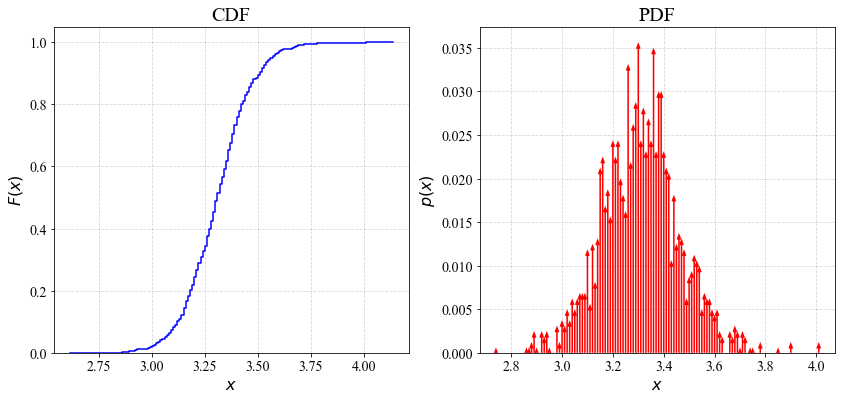

In [6]:
wines_ph = pd.read_csv('winequality-red.csv', sep=';')['pH'].values

edist = EmpiricalDistribution(wines_ph, seed=0)

figsize = (14, 6)
f, axarr = plt.subplots(1, 2, figsize=figsize)

points, cumulatives = edist.get_cdf_data(append_borders=0.1)
plot_empirical_cdf(points, cumulatives, axarr[0], xlabel='$x$', ylabel='$F(x)$', title='CDF')

points, masses = edist.get_pdf_data()
plot_empirical_pdf(points, masses, axarr[1], xlabel='$x$', ylabel='$p(x)$', title='PDF', 
                   arrowwidth=None, headwidth=3, headlength=4, color='r')

### Доверительные интервалы для $F(x)$

Размах интервала Дворецкого-Кифера-Вольфовица: 0.03396315303771529
Размах асим. норм. интервала: 0.012782730861463008


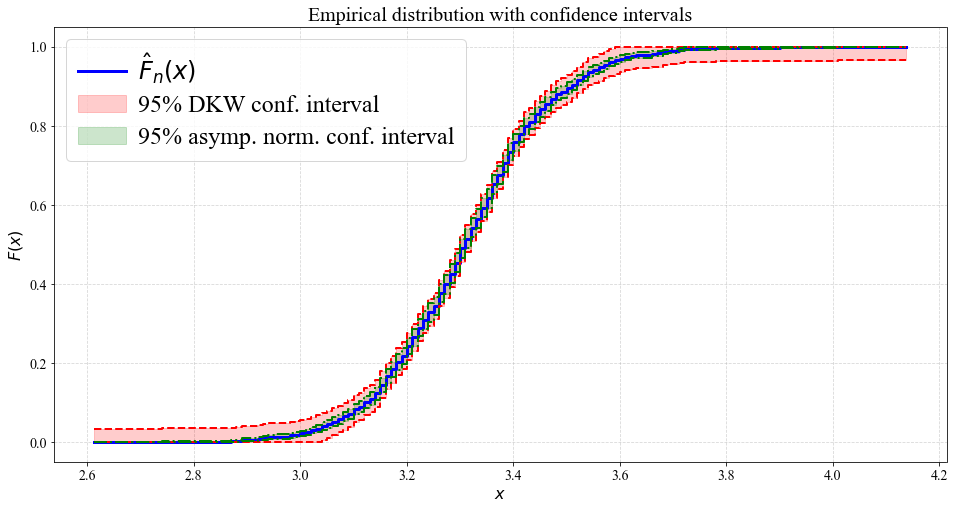

In [7]:
plt.figure(figsize = (16, 8))
matplotlib.rcParams['legend.handletextpad'] = 0.5
n_plot_points = 100
append_borders = 0.1
base_kwargs = {'zorder': 3}
n_samples = len(wines_ph)

plot_dkw_conf = True
plot_asymp_norm_conf = True

# Эмпирическое распределение
empr_kwargs = dict(base_kwargs)
empr_kwargs['color'] = 'b'
empr_kwargs['where'] = 'post'
empr_kwargs['linewidth'] = 3
empr_kwargs['label'] = '$\hat{F}_n(x)$'

# Доверительные интервалы
alpha = 0.05
dkw_conf_kwargs = dict(base_kwargs)
dkw_conf_kwargs['color'] = 'r'
dkw_conf_kwargs['linewidth'] = 2
dkw_conf_kwargs['linestyle'] = '--'
dkw_conf_kwargs['where'] = 'post'

norm_conf_kwargs = dict(base_kwargs)
norm_conf_kwargs['color'] = 'g'
norm_conf_kwargs['linewidth'] = 2
norm_conf_kwargs['linestyle'] = '-.'
norm_conf_kwargs['where'] = 'post'

dkw_fill_kwargs = {}
dkw_fill_kwargs['color'] = 'r'
dkw_fill_kwargs['step'] = 'post'
dkw_fill_kwargs['alpha'] = 0.2
dkw_fill_kwargs['label'] = '{}% DKW conf. interval'.format(int((1 - alpha) * 100))
dkw_fill_kwargs['zorder'] = 2

norm_fill_kwargs = {}
norm_fill_kwargs['color'] = 'g'
norm_fill_kwargs['step'] = 'post'
norm_fill_kwargs['alpha'] = 0.2
norm_fill_kwargs['label'] = '{}% asymp. norm. conf. interval'.format(int((1 - alpha) * 100))
norm_fill_kwargs['zorder'] = 2

# Построение эмпирического распределения и его доверительных интервалов
edist = EmpiricalDistribution(wines_ph)
points, cumulatives = edist.get_cdf_data(append_borders=append_borders)

plt.step(points, cumulatives, **empr_kwargs)

# Доверительный интервал Дворецкого-Кифера-Вольфовица
if plot_dkw_conf:
    dkw = np.sqrt(np.log(2 / alpha) / (2 * n_samples))
    print(f'Размах интервала Дворецкого-Кифера-Вольфовица: {dkw}')
    dkw_upper_bound = np.minimum(cumulatives + dkw, 1)
    dkw_lower_bound = np.maximum(cumulatives - dkw, 0)
    plt.step(points, dkw_upper_bound, **dkw_conf_kwargs)
    plt.step(points, dkw_lower_bound, **dkw_conf_kwargs)
    plt.fill_between(points, dkw_lower_bound, dkw_upper_bound, **dkw_fill_kwargs)

# Асимптотический нормальный доверительный интервал
if plot_asymp_norm_conf:
    z_alpha = scipy.stats.norm.ppf(1 - alpha / 2)
    std = np.sqrt(np.maximum(cumulatives * (1 - cumulatives) / n_samples, 0.0))
    print(f'Размах асим. норм. интервала: {(z_alpha * std).mean()}')
    norm_upper_bound = np.minimum(cumulatives + z_alpha * std, 1)
    norm_lower_bound = np.maximum(cumulatives - z_alpha * std, 0)
    plt.step(points, norm_upper_bound, **norm_conf_kwargs)
    plt.step(points, norm_lower_bound, **norm_conf_kwargs)
    plt.fill_between(points, norm_lower_bound, norm_upper_bound, **norm_fill_kwargs)

plt.legend(loc='upper left', fontsize=24)
plt.xlabel('$x$'); plt.ylabel('$F(x)$')
plt.title('Empirical distribution with confidence intervals')
plt.grid(which='both', linestyle='--', alpha=0.5)
plt.show()

### Оценка функционала $T(F) = F(3.5) - F(3.4)$

Точечная оценка функционала по выборке: $T(X_n) = \hat{F}_n(3.5) - \hat{F}_n(3.4)$

In [9]:
Fn_35 = cumulatives[points.searchsorted(3.5)]
Fn_34 = cumulatives[points.searchsorted(3.4)]
T_Fn = Fn_35 - Fn_34

Из задачи 4 аналитически получили $\hat{se}$ оценки $T(X_n)$:

$$
\hat{se}^2 = \frac{T(\hat{F}_n)(1-T(\hat{F}_n))}{n}.
$$

При этом асимптотический нормальный 95% доверительный интервал для $T(F)$ будет равен (при $\alpha = 0.05$):

$$
\big(T(\hat{F}_n) - z_{1-\alpha/2} \cdot \hat{se}, \space T(\hat{F}_n) + z_{1-\alpha/2} \cdot \hat{se}\big)
$$

In [10]:
alpha = 0.05
z_alpha = scipy.stats.norm.ppf(1 - alpha / 2)
n = len(wines_ph)

se = np.sqrt(T_Fn * (1 - T_Fn) / n)
conf_int = (T_Fn - z_alpha * se, T_Fn + z_alpha * se)

print(f'Оценка se = {se:.4f}')
print(f'Точечная оценка T(Xn) = {T_Fn:.4f}')
print(f'Доверительный интвервал для T(F): ({conf_int[0]:.4f}, {conf_int[1]:.4f})')

Оценка se = 0.0086
Точечная оценка T(Xn) = 0.1370
Доверительный интвервал для T(F): (0.1201, 0.1538)


## Задача 6 [2 балла]

В процессе очистки питьевой воды выпадает значительный осадок. Для его уменьшения можно воздействовать на разные факторы,
в т.ч. на количество микроорганизмов в жидкости, способствующих окислению органики. В группу из $261$ очистительных установок
был добавлен реагент, подавляющих активность микроорганизмов, а состав остальных $119$ остался без изменений.
Пусть $\theta$ - разность в средних значениях количества твердых частиц в этих двух группах установок.
Оценить по данным _WaterTreatment_ величину $\theta$, оценить стандартную ошибку оценки, построить $95\%$ и $99\%$ доверительные интервалы. Какие выводы можно сделать на основе полученных результатов?

### Теоретический вывод

Назовем группу очистительных установок с реагентов - $test$ (размера $n_1$), а без - $control$ (размера $n_2$). Рассматриваем величину: 

$$
\theta = \mu_{test} - \mu_{control},
$$

где $\mu = T(F) = \int xdF(x)$ - матожидание (статистический функционал).

Имея выборку из $F(x)$, знаем оценку: $\hat{\mu} = \int xd\hat{F_n}(x) = \overline{X_n}$, откуда получаем точечную оценку: 
$$\hat{\theta_n} = \overline{X_{test}} - \overline{X_{control}}.$$

Оценим стандартную ошибку оценки: 
$$\hat{se}^2 = \mathbb{V}(\hat{\theta_n}) = \mathbb{V}(\overline{X_{test}}) + \mathbb{V}(\overline{X_{control}}) = \frac{\hat{\sigma}_{test}^2}{n_1} + \frac{\hat{\sigma}_{control}^2}{n_2},$$

т.к. выборки независимы и ковариация равна 0.

Используем (смещенную) оценку дисперсии для каждой из выборок (отдельно $test$ и $control$): 
$$\hat{\sigma}^2 = \frac{1}{n}\sum_{i=1}^{n}(X_i-\overline{X_n})^2, \space n \in \{n_1, n_2\}.$$ 

Доверительным интервалом для оценки будет: 
$$\big(\hat{\theta_n} - z_{1-\alpha/2} \cdot \sqrt{\frac{\hat{\sigma}_{test}^2}{n_1} + \frac{\hat{\sigma}_{control}^2}{n_2}}, \space \hat{\theta_n} + z_{1-\alpha/2} \cdot \sqrt{\frac{\hat{\sigma}_{test}^2}{n_1} + \frac{\hat{\sigma}_{control}^2}{n_2}} \big)$$

### Расчет на данных

In [10]:
water = pd.read_csv('WaterTreatment.csv', sep=',')
water_test = water[water['reduced_microorganism'] == 1]['sediment'].values
water_control = water[water['reduced_microorganism'] == 0]['sediment'].values

In [11]:
alpha_1 = 0.05
alpha_2 = 0.01
z_alpha_1 = scipy.stats.norm.ppf(1 - alpha_1 / 2)
z_alpha_2 = scipy.stats.norm.ppf(1 - alpha_2 / 2)

theta = water_test.mean() - water_control.mean()
n_1 = len(water_test)
n_2 = len(water_control)
sigma_test = np.std(water_test, ddof=0)
sigma_control = np.std(water_control, ddof=0)
root = np.sqrt(sigma_test**2 / n_1 + sigma_control**2 / n_2)

conf_int_95 = (theta - z_alpha_1 * root, theta + z_alpha_1 * root)
conf_int_99 = (theta - z_alpha_2 * root, theta + z_alpha_2 * root)

In [12]:
print(f'Точечная оценка theta: {theta:.4f}')
print(f'95% доверительный интервал: ({conf_int_95[0]:.4f}, {conf_int_95[1]:.4f})')
print(f'99% доверительный интервал: ({conf_int_99[0]:.4f}, {conf_int_99[1]:.4f})')

Точечная оценка theta: -0.0713
95% доверительный интервал: (-0.1346, -0.0081)
99% доверительный интервал: (-0.1544, 0.0118)


### Выводы

* На уровне значимости $\alpha = 0.05$ __есть__ стат. значимая разница в среднем кол-ве твердых частиц, в тестовой выборке с реагентом их меньше, __95% доверительный интервал не содержит точки 0__
* На уровне значимости $\alpha = 0.01$ __нет__ стат. значимой разницы в среднем кол-ве твердых частиц, __99% доверительный интервал содержит точку 0__

## Бутстреп

## Задача 7 [3 балла]

Провести моделирование, чтобы сравнить различные типы доверительных интервалов, построенных с помощью бутстрепа. Пусть $n = 50$, $T(F) = \int (x-\mu)^3 dF(x) / \sigma^{3}$ - коэффициент асимметрии, где $F$ - логнормальное распределение. Постройте 95\% доверительные интервалы для $T(F)$ (под $F$ понимается распределение элементов выборки $X_1,\ldots,X_n$) по данным $X^n = \{X_1,\ldots,X_n\}$, используя три подхода на основе бутстрепа.

_Замечение:_ Выборку из логнормального распределения можно сгенерировать из нормального, сначала сгенерировав выборку н.о.р. величин $Y^n = \{Y_1, \ldots,Y_n\} \sim N(0,1)$, после чего положив $X_i = e^{Y_i}$, $i = 1,2,\ldots,n$.

### Генерация выборки

In [13]:
n = 50
gen = scipy.stats.norm(loc=0, scale=1)
norm_sample = gen.rvs(size=n, random_state=42)
log_norm_sample = np.exp(norm_sample)

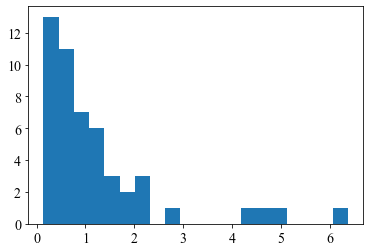

In [14]:
plt.hist(log_norm_sample, bins=20)
plt.show()

### Оценка статистического функционала

$$T(F) = \int\frac{(x-\mu)^3}{\sigma^3}dF(x) = \int\frac{(x-\mu)^3}{\mathbb{V}^{3/2}}dF(x), \space F(x) \sim LogN(\mu,\sigma^2)$$

По выборке $X_n$ из $F(x)$ оценим $T(\hat{F_n})$, посчитав выборочные моменты 2 и 3 порядков, т.к. $(x-\mu)^3$ - третий момент, $\mathbb{V}$ - второй момент. Возьмем несмещенные оценки моментов:

$$
T(\hat{F_n}) = \int\frac{(x-\mu)^3}{\mathbb{V}^{3/2}}dF(x) = \frac{\mathbb{E}(X-\mathbb{E}X)^3}{[\mathbb{E}(X-\mathbb{E}X)^2]^{3/2}} = \frac{n^2}{(n-1)(n-2)} \cdot \big(\frac{n-1}{n}\big)^{3/2} \cdot \frac{\frac{1}{n}\sum_{i=1}^{n}(X_i-\overline{X})^3}{(\frac{1}{n}\sum_{i=1}^{n}(X_i-\overline{X})^2)^{3/2}} = \frac{\sqrt{n(n-1)}}{n-2} \cdot \frac{\frac{1}{n}\sum_{i=1}^{n}(X_i-\overline{X})^3}{(\frac{1}{n}\sum_{i=1}^{n}(X_i-\overline{X})^2)^{3/2}}
$$

In [15]:
def get_T_Fn(sample):
    return (
        (np.sqrt(n * (n - 1)) / (n - 2)) *
        (stats.moment(sample, moment=3) / 
         stats.moment(sample, moment=2) ** (3/2))
    )

### Бутстреп и доверительные интервалы

In [16]:
alpha = 0.05

bootstrap = Bootstrap(log_norm_sample, get_T_Fn, seed=1)
bootstrap_size = 5000

for i in range(bootstrap_size):
    bootstrap.generate(return_samples=False)

In [17]:
print('Оценка статистики на основе начальной выборки:', get_T_Fn(log_norm_sample))
print('Бутстрепная оценка статистики:', np.mean(bootstrap.get_statistics()))
print('Нормальный доверительный интервал: ', bootstrap.get_normal_interval(alpha))
print('Центральный доверительный интервал:', bootstrap.get_central_interval(alpha))
print('Квантильный доверительный интервал:', bootstrap.get_percentile_interval(alpha))

Оценка статистики на основе начальной выборки: 2.2964352504475247
Бутстрепная оценка статистики: 2.202403331427309
Нормальный доверительный интервал:  (1.3427340703099477, 3.2501364305851017)
Центральный доверительный интервал: (1.308025682738426, 3.216689248973787)
Квантильный доверительный интервал: (1.3761812519212626, 3.2848448181566234)


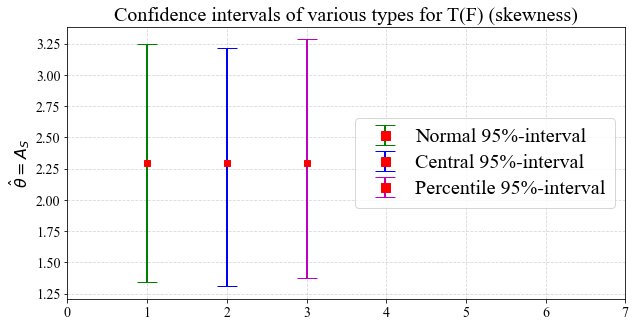

In [18]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))

conf_data = get_all_bootstrap_intervals(bootstrap, alpha)
plot_confidence_intervals(conf_data, 
                          ax, 
                          ylabel=r'$\hat{\theta}=A_S$',
                          title='Confidence intervals of various types for T(F) (skewness)')

### Выводы

* Доверительные интервалы, построенные тремя разными способами, дали схожие результаты
* Все доверительные интервалы лежат правее 0, что стат. значимо означает, что коэффициент ассиметрии положительный, то есть правый хвост распределения длинее, что согласуется с гистограммой сэмпла распределения

## Задача 9 [2 балла]

Пусть $X^n = \{X_1,\ldots, X_n\} \sim N(\mu, 1)$, $\theta = e^{\mu}$ и $\hat{\theta} = e^{\overline{X^n}}$. 
Сгенерируйте выборку $X^n$ из $n = 100$ наблюдений для $\mu = 10$.
Нарисуйте гистограмму  значений $\{\hat{\theta}^*_i\}_{i=1}^B$ бутстрепных оценок. Эта гистограмма является оценкой распределения $p_{\hat{\theta}}(x)$. Сравните ее с настоящим распределением $p_{\hat{\theta}}(x)$.
Используя бутстреп, подсчитайте величину $se$ и постройте тремя способами $95\%$ доверительный интервал для $\theta$.

### Генерация выборки

In [19]:
n = 100
mu = 10
std = 1
gen = scipy.stats.norm(loc=mu, scale=std)
norm_sample = gen.rvs(size=n, random_state=42)

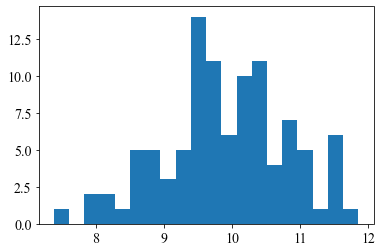

In [20]:
plt.hist(norm_sample, bins=20)
plt.show()

### Стат. функционалы $\theta, se$ и $p_{\hat{\theta}}(x)$ из задачи 8

In [21]:
def theta(samples):
    return np.exp(samples.mean())

def se(samples):
    return np.std(samples, ddof=0)

def p_theta(x, mu, sigma, n):
    return (
        np.sqrt(n)/(x*sigma*np.sqrt(2*np.pi)) * 
        np.exp(-n*(np.log(x)-mu)**2/(2*sigma**2))
    )

### Гистограмма бустреп оценок $\{\hat{\theta^{*}_i}\}^{B}_{i=1}$ vs. истинное распределение $p_{\hat{\theta}}(x)$

Бутстреп

In [23]:
bootstrap = Bootstrap(norm_sample, theta, seed=1)
bootstrap_size = 5000

for i in range(bootstrap_size):
    bootstrap.generate(return_samples=False)

Истинное распределение (+проверка scipy vs. аналитически полученное)

In [27]:
lognorm = scipy.stats.lognorm(scale=np.exp(mu), s=1/np.sqrt(n))
x = np.linspace(lognorm.ppf(0.001),
                lognorm.ppf(0.999), 100)
y = p_theta(x, mu, std, n)

assert np.allclose(lognorm.pdf(x), y), 'PDFs do not match!'

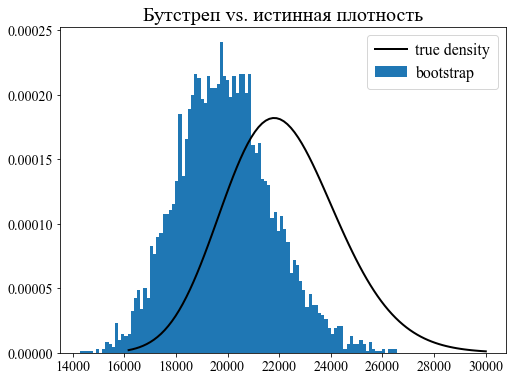

In [28]:
plt.figure(figsize=(8,6))
plt.hist(bootstrap.get_statistics(), bins=100, density=True, label='bootstrap')
plt.plot(x, y, 'k-', lw=2, label='true density')
plt.title('Бутстреп vs. истинная плотность')
plt.legend()
plt.show()

* Бутстреп распределение не точно совпадает и смещено слево, это из-за маленькой выборки (n=100), так как небольшой сэмпл данных плохо описывает случайную величину. При бОльших n (>10k) распределения практически совпадают.

### Оценка $se$ и доверительные интервалы для $\theta$

In [29]:
se_boot = np.mean(se(bootstrap.get_statistics()))
print('Бутстреп оценка se:', se_boot)

Бутстреп оценка se: 1822.5081119600297


In [31]:
print('Оценка theta на основе начальной выборки:', theta(norm_sample))
print('Бутстрепная оценка theta:', np.mean(bootstrap.get_statistics()))
print('Нормальный доверительный интервал: ', bootstrap.get_normal_interval(alpha))
print('Центральный доверительный интервал:', bootstrap.get_central_interval(alpha))
print('Квантильный доверительный интервал:', bootstrap.get_percentile_interval(alpha))

Оценка theta на основе начальной выборки: 19853.85517465637
Бутстрепная оценка theta: 19906.369113926175
Нормальный доверительный интервал:  (16281.80491368262, 23425.905435630124)
Центральный доверительный интервал: (15954.096627711431, 23154.30987147862)
Квантильный доверительный интервал: (16553.400477834122, 23753.613721601312)


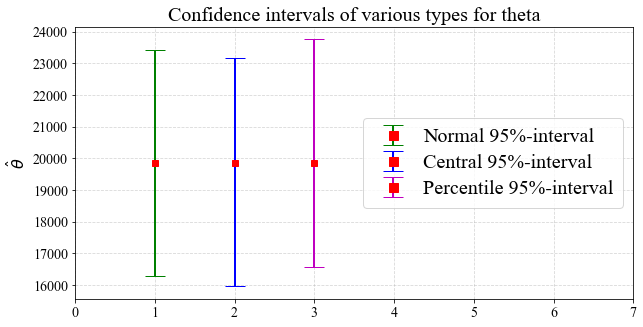

In [32]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))

alpha = 0.05
conf_data = get_all_bootstrap_intervals(bootstrap, alpha)
plot_confidence_intervals(conf_data, 
                          ax, 
                          ylabel=r'$\hat{\theta}$',
                          title='Confidence intervals of various types for theta')

### Вывод

* Доверительные интервалы, построенные тремя разными способами, дали схожие результаты
* Интервал на основе перцентилей чуть лучше приближает истинное распределение - находится правее по оси, ближе к $p_{\hat{\theta}}(x)$